In [1]:
#%load_ext autoreload
#%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


# basic functionalities
import re
import os
import sys
import datetime
import itertools
import math 


# data transforamtion and manipulation
import pandas as pd
import pandas_datareader.data as web
import numpy as np
# prevent crazy long pandas prints
pd.options.display.max_columns = 16
pd.options.display.max_rows = 16
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(precision=5, suppress=True)
pd.options.mode.chained_assignment = None


# remove warnings
import warnings
warnings.filterwarnings('ignore')


# plotting and plot stying
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
plt.style.use('seaborn')
#sns.set_style("whitegrid", {'axes.grid' : False})
#set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 80
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['text.usetex'] = False
#plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.latex.preamble'] = b"\usepackage{subdepth}, \usepackage{type1cm}"


# statistical modeling libraries
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
#from arch import arch_model


# deep learning
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import plot_model 


# jupyter wdgets
from ipywidgets import interactive, widgets, RadioButtons, ToggleButtons, Select, FloatSlider, FloatProgress
from IPython.display import set_matplotlib_formats, Image


ModuleNotFoundError: No module named 'keras'

# Tensorflow Neural network Prediction

## What can tensorflow do?

The short answer: it allows machine learning researcher to experiment with deep neural nets  more easily. Here, "more easily" means it takes less time to construct artificial neural networks, less time to train them (this is arguable, as is always the case when speed is concerned), and less time to deploy them.

**Do not expect:** do not expect magic things to come from TensorFlow. There is none. A wealth of deep learning frameworks already exist in the wild and TensorFlow is just one of them. It will not give you powerful AI overnight, nor will it help your smartphone to recognize cats. It is a tool for deep learning research that will hopefully make it a bit less cumbersome.

**Who should be excited:** deep learning researchers who construct and experiment with large number of networks, researchers who are too lazy to get their hands dirty on serious code, and companies that benefit from being able to quickly train and deploy their models. Basically if you consider yourself a member of the general public, it's got nothing to do with you.


## The model in theory

https://github.com/alberduris/SirajsCodingChallenges/tree/master/Stock%20Market%20Prediction

We are going to use 4 features: The **price** itself and three extra technical indicators.
- MACD (Trend)
- Stochastics (Momentum)
- Average True Range (Volume)


## Feature Engineering

**Exponential Moving Average:** Is a type of infinite impulse response filter that applies weighting factors which decrease exponentially. The weighting for each older datum decreases exponentially, never reaching zero. 
<img src="https://www.bionicturtle.com/images/uploads/WindowsLiveWriterGARCHapproachandExponentialsmoothingEWMA_863image_16.png">

**MACD:**  The Moving Average Convergence/Divergence oscillator (MACD) is one of the simplest and most effective momentum indicators available. The MACD turns two trend-following indicators, moving averages, into a momentum oscillator by subtracting the longer moving average from the shorter moving average.
<img src="http://i68.tinypic.com/289ie1l.png">

**Stochastics oscillator:** The Stochastic Oscillator is a momentum indicator that shows the location of the close relative to the high-low range over a set number of periods.

<img src="http://i66.tinypic.com/2vam3uo.png">

**Average True Range:** Is an indicator to measure the volalitility (NOT price direction). The largest of:
- Method A: Current High less the current Low
- Method B: Current High less the previous Close (absolute value)
- Method C: Current Low less the previous Close (absolute value)

<img src="http://d.stockcharts.com/school/data/media/chart_school/technical_indicators_and_overlays/average_true_range_atr/atr-1-trexam.png" width="400px">

Calculation:
<img src="http://i68.tinypic.com/e0kggi.png">

In [2]:
def MACD(df, period1, period2, periodSignal):
    EMA1 = pd.DataFrame.ewm(df, span=period1).mean()
    EMA2 = pd.DataFrame.ewm(df, span=period2).mean()
    MACD = EMA1 - EMA2
    
    Signal = pd.DataFrame.ewm(MACD, periodSignal).mean()
    
    Histogram = MACD - Signal
    
    return Histogram

def stochastics_oscillator(df, period):
    l, h = pd.DataFrame.rolling(df, period).min(), pd.DataFrame.rolling(df, period).max()
    k = 100 * (df - l) / (h - l)
    return k

def ATR(df,period):
    '''
    Method A: Current High less the current Low
    '''
    df['H-L'] = abs(df['High'] - df['Low'])
    df['H-PC'] = abs(df['High'] - df['Close'].shift(1))
    df['L-PC'] = abs(df['Low'] - df['Close'].shift(1))
    TR = df[['H-L','H-PC','L-PC']].max(axis=1)
    return TR.to_frame()

In [3]:
df = pd.read_csv('./data/EURUSD.csv', usecols=[1,2,3,4])
df = df.iloc[::-1]
df["Close"] = (df["Close"].str.split()).apply(lambda x: float(x[0].replace(',', '.')))
df["Open"] = (df["Open"].str.split()).apply(lambda x: float(x[0].replace(',', '.')))
df["High"] = (df["High"].str.split()).apply(lambda x: float(x[0].replace(',', '.')))
df["Low"] = (df["Low"].str.split()).apply(lambda x: float(x[0].replace(',', '.')))


dfPrices = pd.read_csv('./data/EURUSD.csv',usecols=[1])
dfPrices = dfPrices.iloc[::-1]
dfPrices["Close"] = (dfPrices["Close"].str.split()).apply(lambda x: float(x[0].replace(',', '.')))

In [4]:
dfPrices.head()

,Close
2629,1.36110
2628,1.35370
2627,1.34260
2626,1.34240
2625,1.34760


# Plotting

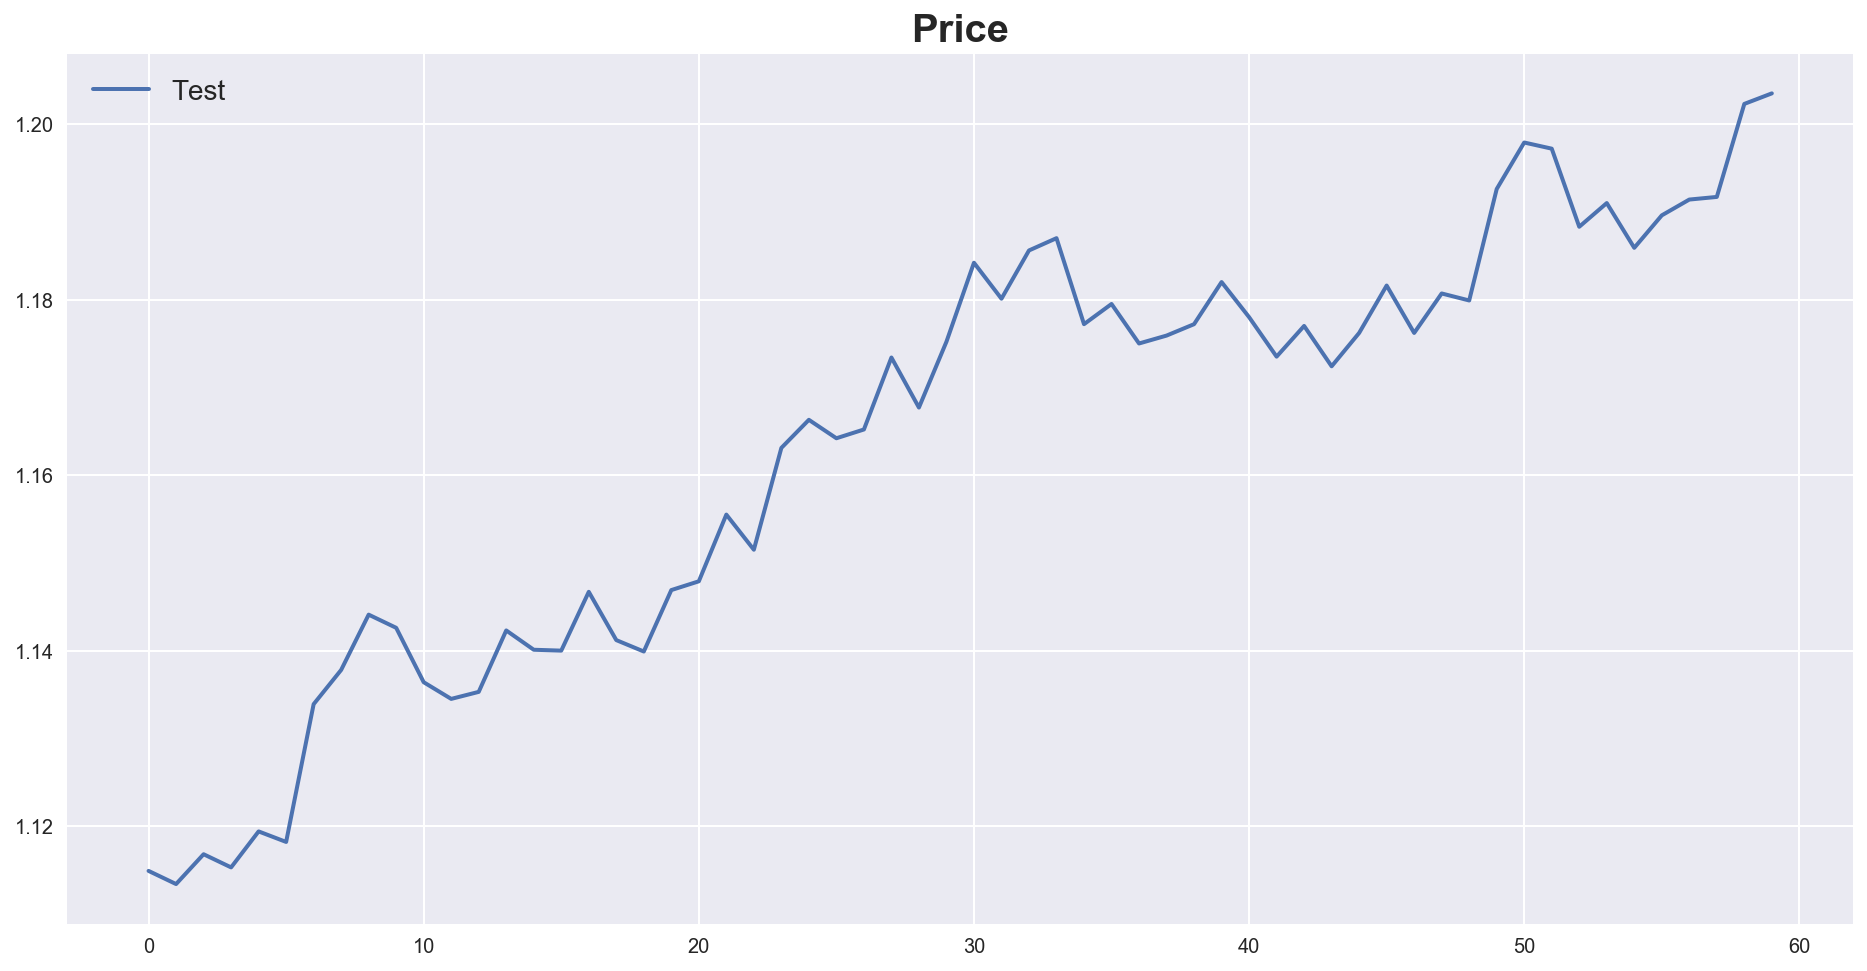

In [5]:
price = dfPrices.iloc[len(dfPrices.index)-60:len(dfPrices.index)].as_matrix().ravel()
prices = dfPrices.iloc[len(dfPrices.index)-60:len(dfPrices.index)].as_matrix().ravel()
plt.figure()
plt.plot(prices,label='Test')
plt.title('Price')
plt.legend(loc='upper left')
plt.show()

### MACD

In [6]:
macd = MACD(dfPrices.iloc[len(dfPrices.index)-60:len(dfPrices.index)],12,26,9)

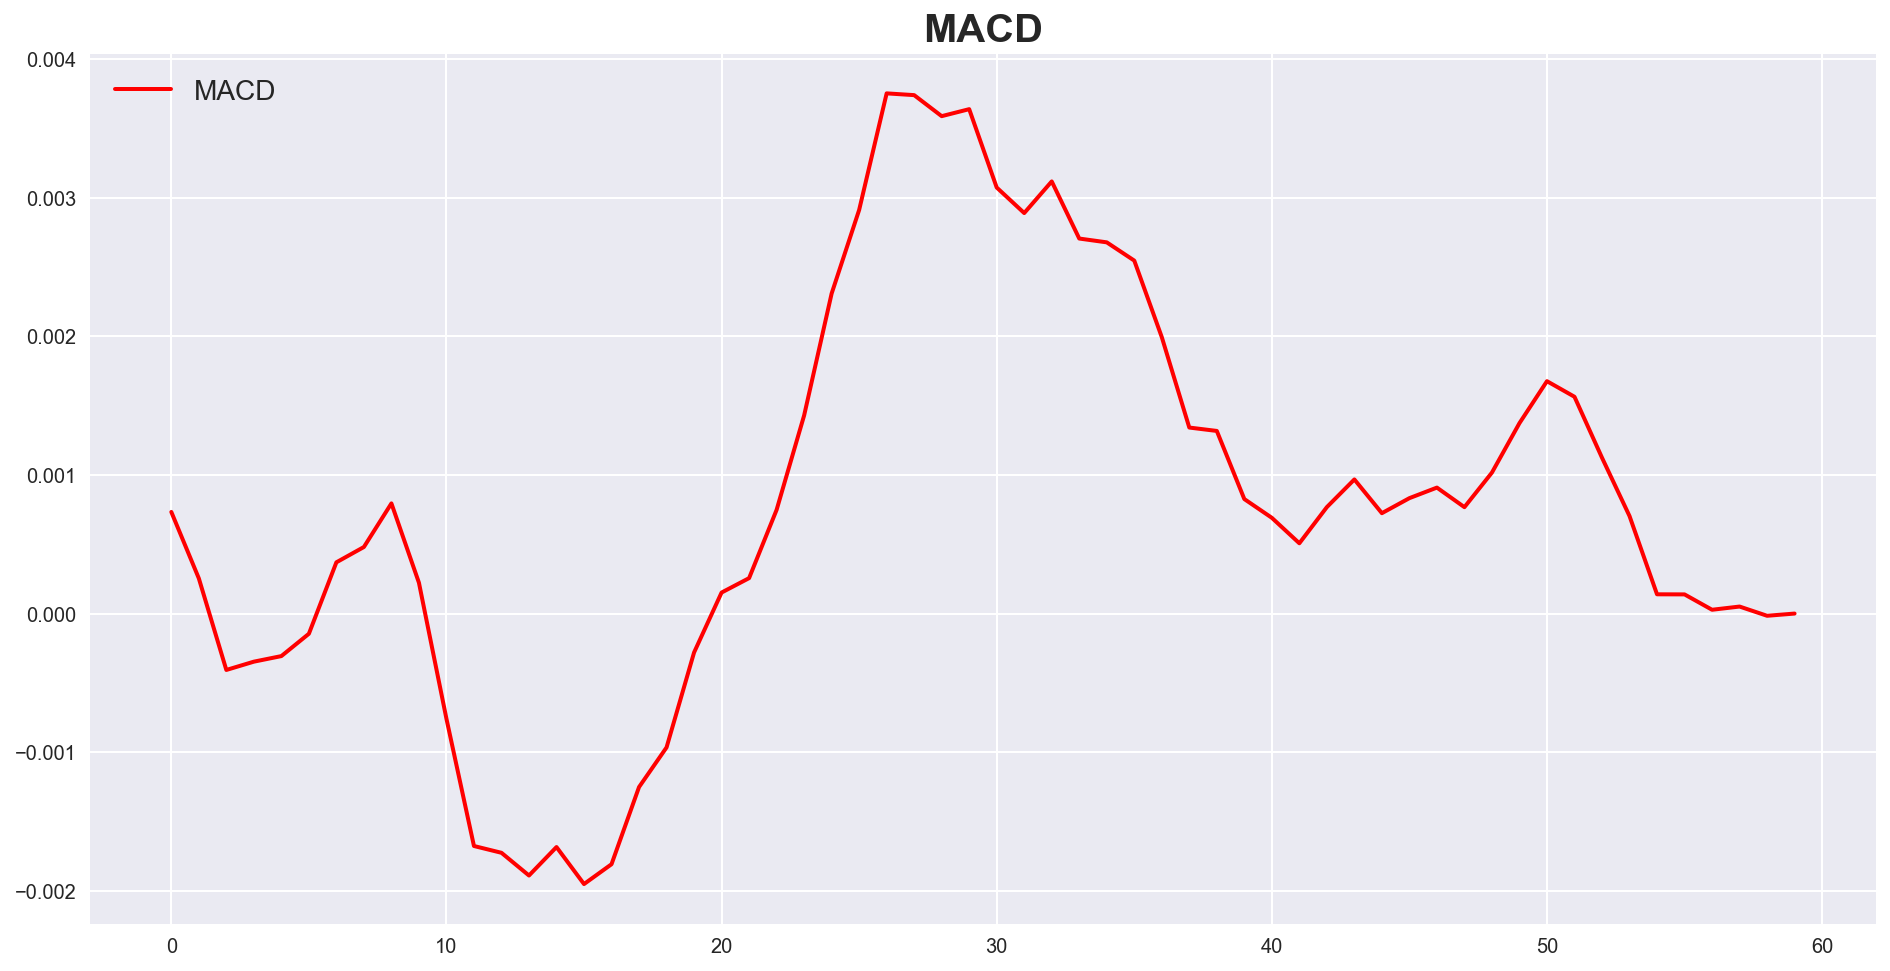

In [7]:
plt.figure()
plt.plot(macd, label='MACD', color='red')
plt.title('MACD')
plt.legend(loc='upper left')
plt.show()

### Stochastics Oscillator

In [8]:
stochastics = stochastics_oscillator(dfPrices.iloc[len(dfPrices.index)-60:len(dfPrices.index)],14)

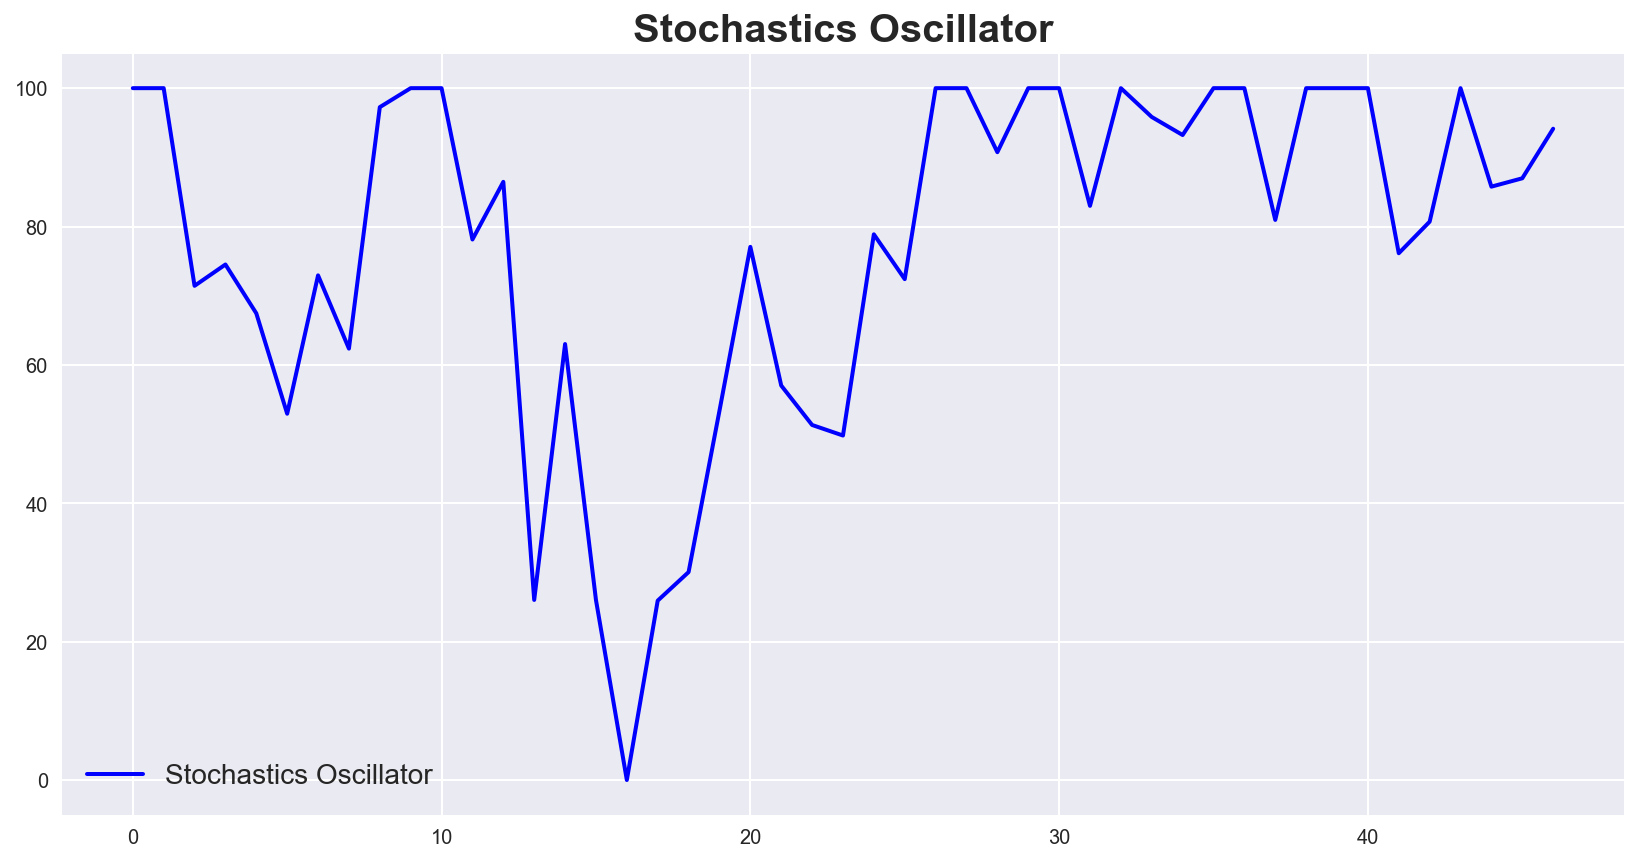

In [9]:
plt.figure(figsize=(14,7))
#First 100 points because it's too dense
plt.plot(stochastics[0:100],label='Stochastics Oscillator',color='blue')
plt.title('Stochastics Oscillator')
plt.legend(loc='best')
plt.show()

### Average True Range

In [10]:
atr = ATR(df.iloc[len(df.index)-60:len(df.index)],14)

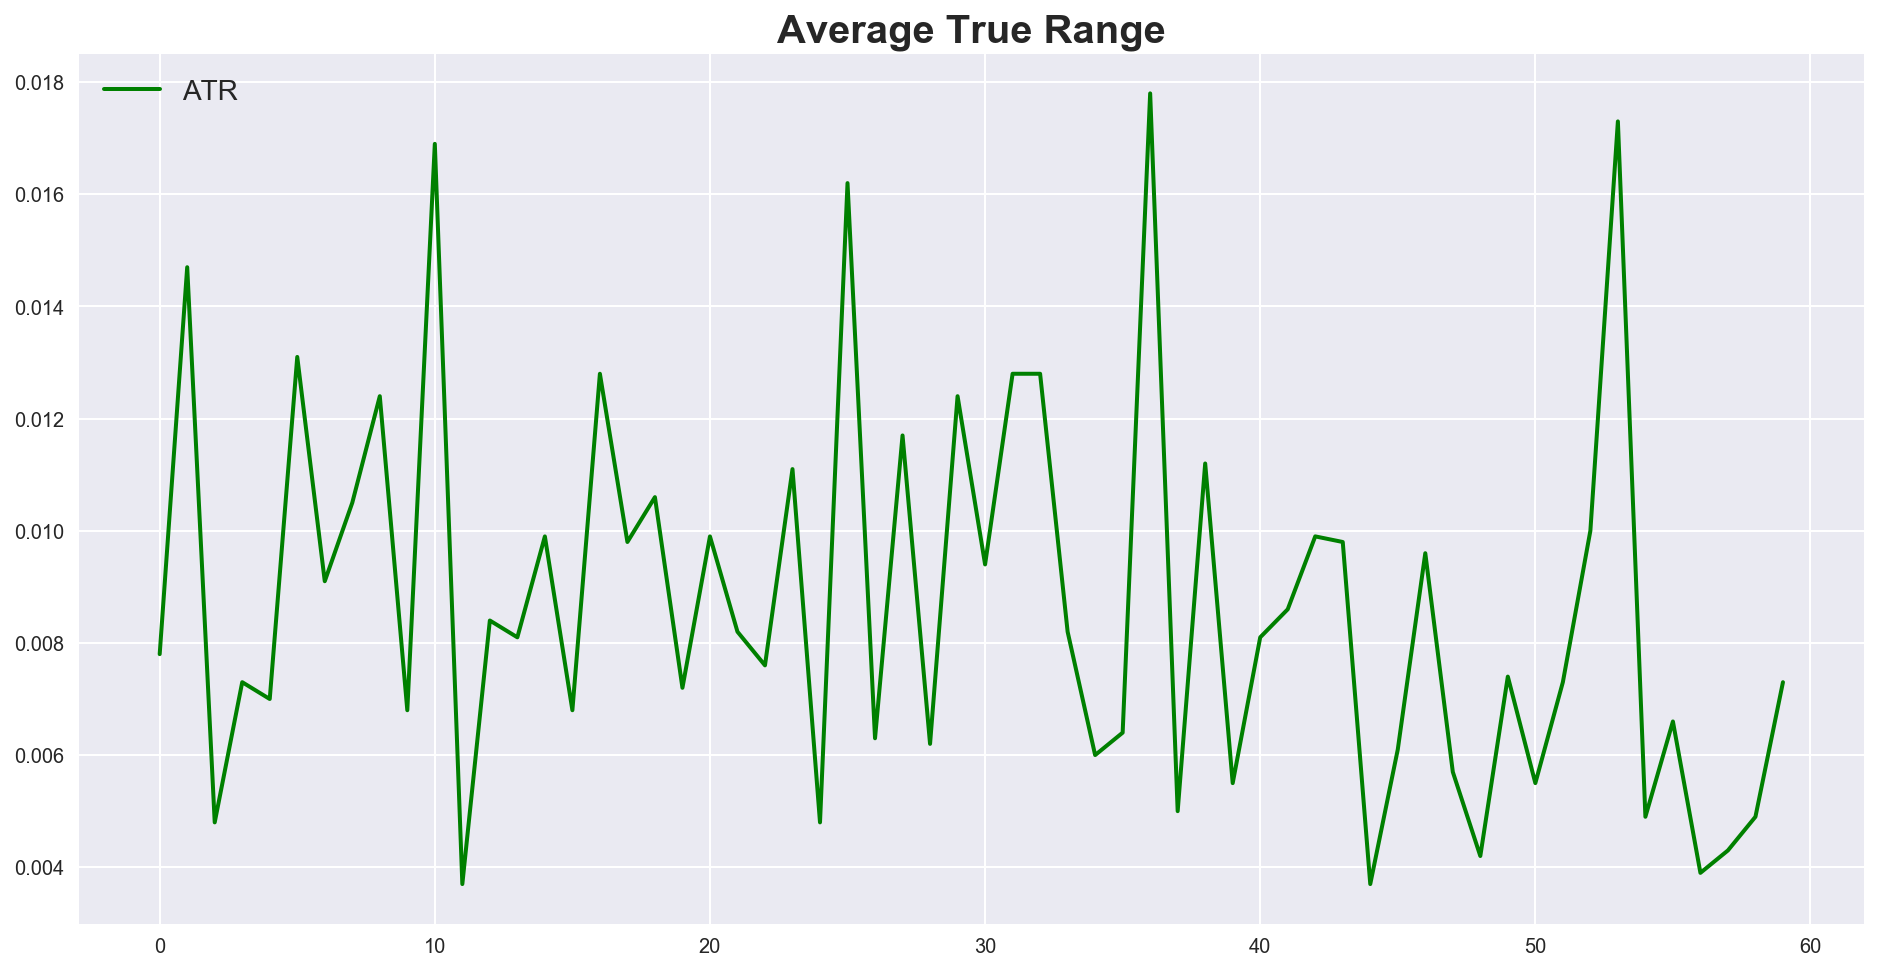

In [11]:
plt.figure()
#First 100 points because it's too dense
plt.plot(atr[0:100], label='ATR', color='green')
plt.title('Average True Range')
plt.legend(loc='upper left')
plt.show()

## Create complete DataFrame & Save Data

In [12]:
dfPriceShift = dfPrices.shift(-1)
dfPriceShift.rename(columns={'Close':'CloseTarget'}, inplace=True)

In [13]:
dfPriceShift.head()

,CloseTarget
2629,1.35370
2628,1.34260
2627,1.34240
2626,1.34760
2625,1.34730


In [14]:
macd = MACD(dfPrices,12,26,9)
macd.rename(columns={'Close':'MACD'}, inplace=True)

stochastics = stochastics_oscillator(dfPrices,14)
stochastics.rename(columns={'Close':'Stochastics'}, inplace=True)

atr = ATR(df,14)
atr.rename(columns={0:'ATR'}, inplace=True)

# concatenate all together
final_data = pd.concat([dfPrices,dfPriceShift,macd,stochastics,atr], axis=1)
# Delete the entries with missing values (where the stochastics couldn't be computed yet) because have a lot of datapoints ;)
final_data = final_data.dropna()

In [15]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2616 entries, 2616 to 1
Data columns (total 5 columns):
Close          2616 non-null float64
CloseTarget    2616 non-null float64
MACD           2616 non-null float64
Stochastics    2616 non-null float64
ATR            2616 non-null float64
dtypes: float64(5)
memory usage: 122.6 KB


In [16]:
final_data

,Close,CloseTarget,MACD,Stochastics,ATR
2616,1.36380,1.36300,0.00132,83.26848,0.00860
2615,1.36300,1.36210,0.00114,80.15564,0.01000
2614,1.36210,1.36070,0.00091,76.65370,0.00530
2613,1.36070,1.36500,0.00064,71.20623,0.00760
2612,1.36500,1.36890,0.00066,85.84475,0.01040
2611,1.36890,1.37680,0.00086,100.00000,0.00760
2610,1.37680,1.37980,0.00140,100.00000,0.01360
2609,1.37980,1.38380,0.00189,100.00000,0.00500
...,...,...,...,...,...
8,1.19720,1.18830,-0.00003,97.25490,0.01240


In [17]:
final_data.to_csv('./data/EURUSD_indicators.csv', index=False)

# Recurrent Neural Network

In [18]:
import tensorflow as tf

In [19]:
dataset = pd.read_csv('./data/EURUSD_indicators.csv')
dataset.head()

,Close,CloseTarget,MACD,Stochastics,ATR
0,1.36380,1.36300,0.00132,83.26848,0.00860
1,1.36300,1.36210,0.00114,80.15564,0.01000
2,1.36210,1.36070,0.00091,76.65370,0.00530
3,1.36070,1.36500,0.00064,71.20623,0.00760
4,1.36500,1.36890,0.00066,85.84475,0.01040


In [21]:
# normalize
datasetNorm = (dataset - dataset.mean()) / (dataset.max() - dataset.min())
datasetNorm.head()

,Close,CloseTarget,MACD,Stochastics,ATR
0,0.12130,0.11998,0.02777,0.33638,-0.07637
1,0.11987,0.11837,0.02383,0.30525,-0.04956
2,0.11827,0.11588,0.01904,0.27023,-0.13959
3,0.11577,0.12355,0.01321,0.21575,-0.09553
4,0.12344,0.13052,0.01362,0.36214,-0.04189


In [22]:
# hyperparameters definition
num_epochs = 100

batch_size = 1

total_series_length = len(dataset.index)

truncated_backprop_length = 3 #The size of the sequence

state_size = 12 #The number of neurons

num_features = 4
num_classes = 1 #[1,0]

num_batches = total_series_length // batch_size // truncated_backprop_length

min_test_size = 100

print('The total series length is: %d' %total_series_length)
print('The current configuration gives us %d batches of %d observations each one looking %d steps in the past' 
      %(num_batches,batch_size,truncated_backprop_length))

The total series length is: 2616
The current configuration gives us 872 batches of 1 observations each one looking 3 steps in the past


## Train Test Split

In [23]:
datasetTrain = datasetNorm[dataset.index < num_batches * batch_size * truncated_backprop_length]


for i in range(min_test_size,len(datasetNorm.index)):
    
    if(i % truncated_backprop_length*batch_size == 0):
        test_first_idx = len(datasetNorm.index)-i
        break

datasetTest =  datasetNorm[dataset.index >= test_first_idx]

In [24]:
datasetTrain.head()

,Close,CloseTarget,MACD,Stochastics,ATR
0,0.12130,0.11998,0.02777,0.33638,-0.07637
1,0.11987,0.11837,0.02383,0.30525,-0.04956
2,0.11827,0.11588,0.01904,0.27023,-0.13959
3,0.11577,0.12355,0.01321,0.21575,-0.09553
4,0.12344,0.13052,0.01362,0.36214,-0.04189


In [25]:
datasetTest.head()

,Close,CloseTarget,MACD,Stochastics,ATR
2514,-0.40128,-0.40010,-0.01167,0.34397,-0.16833
2515,-0.40021,-0.39814,-0.00244,0.38563,-0.10511
2516,-0.39825,-0.37332,0.00578,0.46202,-0.13193
2517,-0.37343,-0.36279,0.03266,0.50369,0.15734
2518,-0.36290,-0.36690,0.05952,0.50369,-0.04956


In [26]:
xTrain = datasetTrain[['Close','MACD','Stochastics','ATR']].as_matrix()
yTrain = datasetTrain['CloseTarget'].as_matrix()

In [27]:
print(xTrain[0:3],'\n',yTrain[0:3])

[[ 0.1213   0.02777  0.33638 -0.07637]
 [ 0.11987  0.02383  0.30525 -0.04956]
 [ 0.11827  0.01904  0.27023 -0.13959]] 
 [ 0.11998  0.11837  0.11588]


In [28]:
xTest = datasetTest[['Close','MACD','Stochastics','ATR']].as_matrix()
yTest = datasetTest['CloseTarget'].as_matrix()

In [29]:
print(xTest[0:3],'\n',yTest[0:3])

[[-0.40128 -0.01167  0.34397 -0.16833]
 [-0.40021 -0.00244  0.38563 -0.10511]
 [-0.39825  0.00578  0.46202 -0.13193]] 
 [-0.4001  -0.39814 -0.37332]


## Visualize starting price data

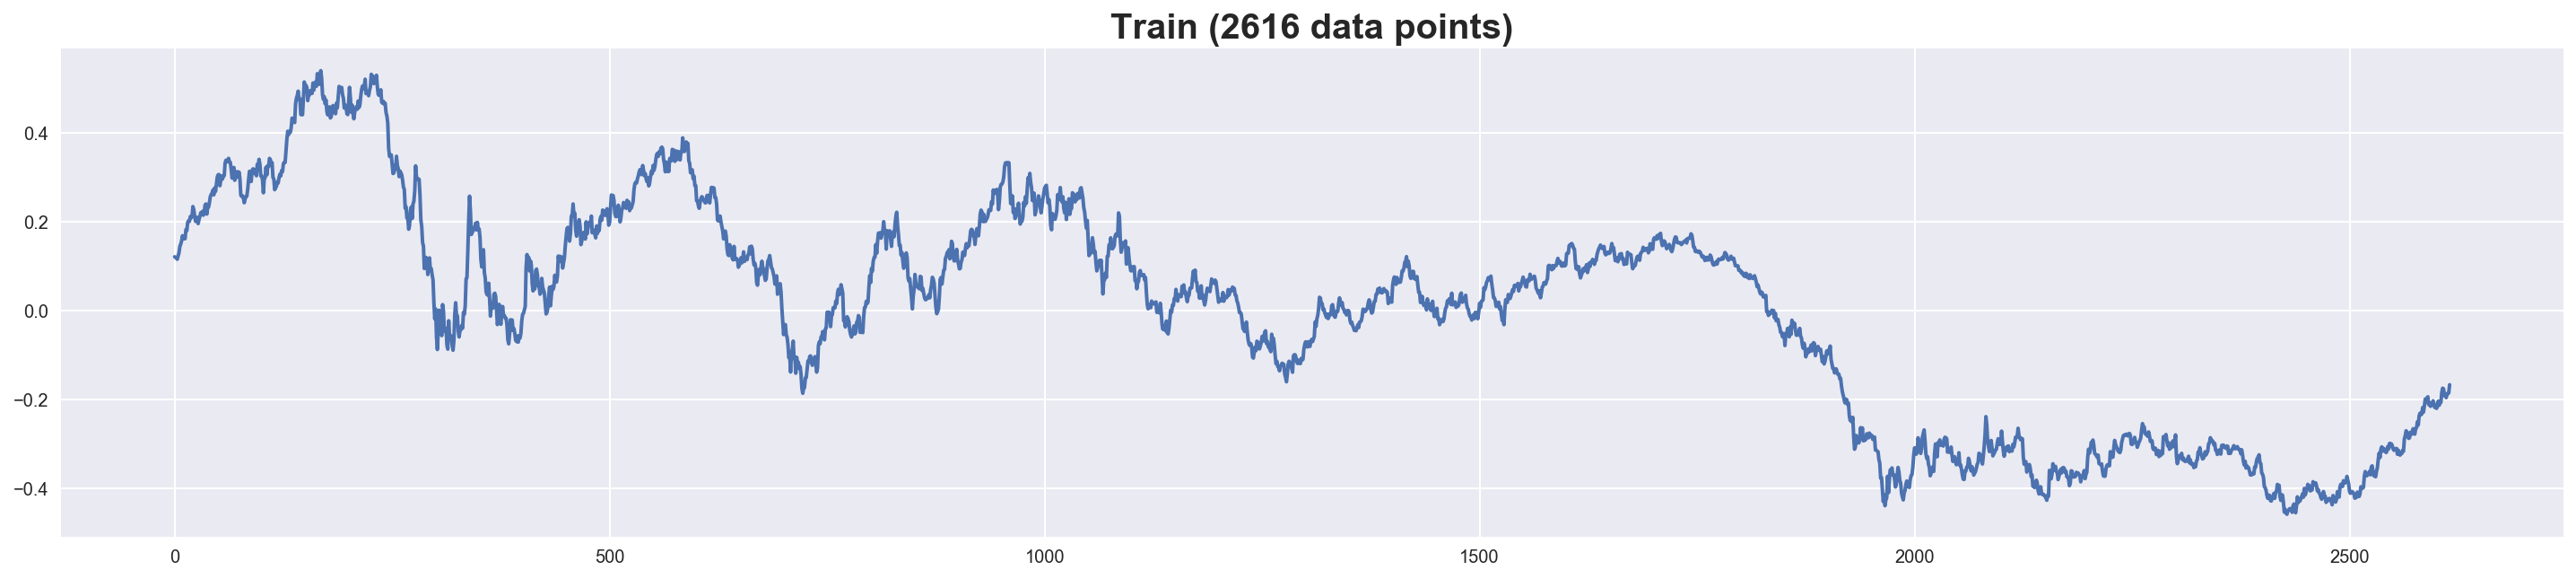

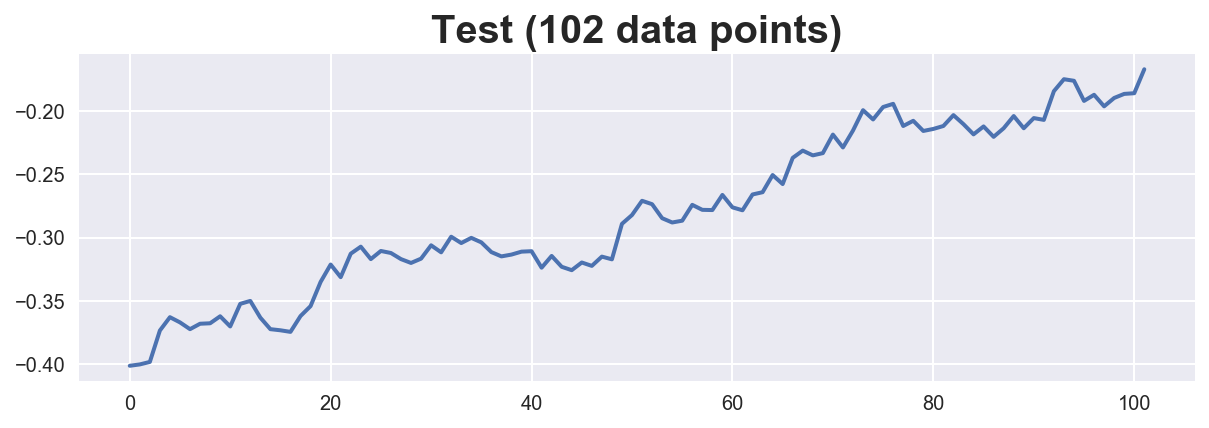

In [30]:
plt.plot(xTrain[:,0])
plt.title('Train (' +str(len(xTrain))+' data points)')
plt.show()
plt.plot(xTest[:,0])
plt.title('Test (' +str(len(xTest))+' data points)')
plt.tight_layout()
plt.show()

## Placeholders

In [31]:
batchX_placeholder = tf.placeholder(dtype=tf.float32,shape=[None,truncated_backprop_length,num_features],name='data_ph')
batchY_placeholder = tf.placeholder(dtype=tf.float32,shape=[None,truncated_backprop_length,num_classes],name='target_ph')

## Weights and biases
Because is a 3 layer net:
1. Input
2. Hidden Recurrent layer
3. Output

We need 2 pairs of W and b

In [32]:
W2 = tf.Variable(initial_value=np.random.rand(state_size,num_classes),dtype=tf.float32)
b2 = tf.Variable(initial_value=np.random.rand(1,num_classes),dtype=tf.float32)

Unpack

In [33]:
labels_series = tf.unstack(batchY_placeholder, axis=1)

## Forward pass - Unroll the cell

Input to recurrent

In [34]:
cell = tf.contrib.rnn.BasicRNNCell(num_units=state_size)

states_series, current_state = tf.nn.dynamic_rnn(cell=cell,inputs=batchX_placeholder,dtype=tf.float32)

In [35]:
states_series = tf.transpose(states_series,[1,0,2])

## Backward pass - Output

In [36]:
last_state = tf.gather(params=states_series,indices=states_series.get_shape()[0]-1)
last_label = tf.gather(params=labels_series,indices=len(labels_series)-1)

## Weights and bias out

In [37]:
weight = tf.Variable(tf.truncated_normal([state_size,num_classes]))
bias = tf.Variable(tf.constant(0.1,shape=[num_classes]))

## Prediction, Loss & Optimizer

In [38]:
prediction = tf.matmul(last_state,weight) + bias
prediction

<tf.Tensor 'add:0' shape=(?, 1) dtype=float32>

In [39]:
loss = tf.reduce_mean(tf.squared_difference(last_label,prediction))

train_step = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

In [40]:
loss_list = []
test_pred_list = []

with tf.Session() as sess:
    
    tf.global_variables_initializer().run()
    
    for epoch_idx in range(num_epochs):
                
        print('Epoch %d' %epoch_idx)
        
        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length * batch_size
        
            
            batchX = xTrain[start_idx:end_idx,:].reshape(batch_size,truncated_backprop_length,num_features)
            batchY = yTrain[start_idx:end_idx].reshape(batch_size,truncated_backprop_length,1)
                
            #print('IDXs',start_idx,end_idx)
            #print('X',batchX.shape,batchX)
            #print('Y',batchX.shape,batchY)
            
            feed = {batchX_placeholder : batchX, batchY_placeholder : batchY}
            
            #TRAIN!
            _loss,_train_step,_pred,_last_label,_prediction = sess.run(
                fetches=[loss,train_step,prediction,last_label,prediction],
                feed_dict = feed
            )
            
            loss_list.append(_loss)

            
            if(batch_idx % 50 == 0):
                print('Step %d - Loss: %.6f' %(batch_idx,_loss))
                
    #TEST
    
    
    for test_idx in range(len(xTest) - truncated_backprop_length):
        
        testBatchX = xTest[test_idx:test_idx+truncated_backprop_length,:].reshape((1,truncated_backprop_length,num_features))        
        testBatchY = yTest[test_idx:test_idx+truncated_backprop_length].reshape((1,truncated_backprop_length,1))

        #_current_state = np.zeros((batch_size,state_size))
        feed = {batchX_placeholder : testBatchX,
            batchY_placeholder : testBatchY}

        #Test_pred contains 'window_size' predictions, we want the last one
        _last_state,_last_label,test_pred = sess.run([last_state,last_label,prediction],feed_dict=feed)
        test_pred_list.append(test_pred[-1][0]) #The last one

Epoch 0
Step 0 - Loss: 0.026227
Step 50 - Loss: 0.000528
Step 100 - Loss: 0.045964
Step 150 - Loss: 0.034961
Step 200 - Loss: 0.002900
Step 250 - Loss: 0.005142
Step 300 - Loss: 0.000215
Step 350 - Loss: 0.003184
Step 400 - Loss: 0.000167
Step 450 - Loss: 0.000648
Step 500 - Loss: 0.001682
Step 550 - Loss: 0.000002
Step 600 - Loss: 0.000147
Step 650 - Loss: 0.001292
Step 700 - Loss: 0.000002
Step 750 - Loss: 0.001132
Step 800 - Loss: 0.000961
Step 850 - Loss: 0.000004
Epoch 1
Step 0 - Loss: 0.000000
Step 50 - Loss: 0.000041
Step 100 - Loss: 0.025668
Step 150 - Loss: 0.000483
Step 200 - Loss: 0.000379
Step 250 - Loss: 0.000013
Step 300 - Loss: 0.000337
Step 350 - Loss: 0.001010
Step 400 - Loss: 0.000018
Step 450 - Loss: 0.000399
Step 500 - Loss: 0.000516
Step 550 - Loss: 0.000022
Step 600 - Loss: 0.000001
Step 650 - Loss: 0.000316
Step 700 - Loss: 0.000200
Step 750 - Loss: 0.000029
Step 800 - Loss: 0.000317
Step 850 - Loss: 0.000004
Epoch 2
Step 0 - Loss: 0.000465
Step 50 - Loss: 0.0019

Step 350 - Loss: 0.000048
Step 400 - Loss: 0.000157
Step 450 - Loss: 0.000512
Step 500 - Loss: 0.000213
Step 550 - Loss: 0.000177
Step 600 - Loss: 0.000061
Step 650 - Loss: 0.000265
Step 700 - Loss: 0.000664
Step 750 - Loss: 0.000352
Step 800 - Loss: 0.000197
Step 850 - Loss: 0.000048
Epoch 18
Step 0 - Loss: 0.001199
Step 50 - Loss: 0.003101
Step 100 - Loss: 0.000055
Step 150 - Loss: 0.000313
Step 200 - Loss: 0.000424
Step 250 - Loss: 0.000002
Step 300 - Loss: 0.000623
Step 350 - Loss: 0.000043
Step 400 - Loss: 0.000148
Step 450 - Loss: 0.000546
Step 500 - Loss: 0.000195
Step 550 - Loss: 0.000174
Step 600 - Loss: 0.000062
Step 650 - Loss: 0.000270
Step 700 - Loss: 0.000662
Step 750 - Loss: 0.000336
Step 800 - Loss: 0.000177
Step 850 - Loss: 0.000050
Epoch 19
Step 0 - Loss: 0.001249
Step 50 - Loss: 0.002964
Step 100 - Loss: 0.000017
Step 150 - Loss: 0.000244
Step 200 - Loss: 0.000391
Step 250 - Loss: 0.000006
Step 300 - Loss: 0.000573
Step 350 - Loss: 0.000040
Step 400 - Loss: 0.000141


Step 750 - Loss: 0.000179
Step 800 - Loss: 0.000046
Step 850 - Loss: 0.000082
Epoch 35
Step 0 - Loss: 0.001132
Step 50 - Loss: 0.001790
Step 100 - Loss: 0.001486
Step 150 - Loss: 0.000119
Step 200 - Loss: 0.000381
Step 250 - Loss: 0.000003
Step 300 - Loss: 0.000297
Step 350 - Loss: 0.000004
Step 400 - Loss: 0.000055
Step 450 - Loss: 0.000588
Step 500 - Loss: 0.000066
Step 550 - Loss: 0.000242
Step 600 - Loss: 0.000067
Step 650 - Loss: 0.000218
Step 700 - Loss: 0.000686
Step 750 - Loss: 0.000179
Step 800 - Loss: 0.000046
Step 850 - Loss: 0.000086
Epoch 36
Step 0 - Loss: 0.001100
Step 50 - Loss: 0.001736
Step 100 - Loss: 0.001684
Step 150 - Loss: 0.000135
Step 200 - Loss: 0.000385
Step 250 - Loss: 0.000002
Step 300 - Loss: 0.000292
Step 350 - Loss: 0.000003
Step 400 - Loss: 0.000049
Step 450 - Loss: 0.000588
Step 500 - Loss: 0.000061
Step 550 - Loss: 0.000242
Step 600 - Loss: 0.000066
Step 650 - Loss: 0.000219
Step 700 - Loss: 0.000682
Step 750 - Loss: 0.000179
Step 800 - Loss: 0.000047


Step 500 - Loss: 0.000012
Step 550 - Loss: 0.000225
Step 600 - Loss: 0.000049
Step 650 - Loss: 0.000135
Step 700 - Loss: 0.000435
Step 750 - Loss: 0.000063
Step 800 - Loss: 0.000123
Step 850 - Loss: 0.000164
Epoch 70
Step 0 - Loss: 0.000381
Step 50 - Loss: 0.000805
Step 100 - Loss: 0.004334
Step 150 - Loss: 0.000460
Step 200 - Loss: 0.000463
Step 250 - Loss: 0.000020
Step 300 - Loss: 0.000126
Step 350 - Loss: 0.000007
Step 400 - Loss: 0.000004
Step 450 - Loss: 0.000353
Step 500 - Loss: 0.000012
Step 550 - Loss: 0.000224
Step 600 - Loss: 0.000049
Step 650 - Loss: 0.000136
Step 700 - Loss: 0.000436
Step 750 - Loss: 0.000061
Step 800 - Loss: 0.000121
Step 850 - Loss: 0.000163
Epoch 71
Step 0 - Loss: 0.000375
Step 50 - Loss: 0.000795
Step 100 - Loss: 0.004308
Step 150 - Loss: 0.000450
Step 200 - Loss: 0.000455
Step 250 - Loss: 0.000021
Step 300 - Loss: 0.000124
Step 350 - Loss: 0.000007
Step 400 - Loss: 0.000004
Step 450 - Loss: 0.000353
Step 500 - Loss: 0.000012
Step 550 - Loss: 0.000223


Step 50 - Loss: 0.000964
Step 100 - Loss: 0.003642
Step 150 - Loss: 0.000266
Step 200 - Loss: 0.000315
Step 250 - Loss: 0.000026
Step 300 - Loss: 0.000068
Step 350 - Loss: 0.000014
Step 400 - Loss: 0.000009
Step 450 - Loss: 0.000271
Step 500 - Loss: 0.000011
Step 550 - Loss: 0.000229
Step 600 - Loss: 0.000053
Step 650 - Loss: 0.000115
Step 700 - Loss: 0.000414
Step 750 - Loss: 0.000043
Step 800 - Loss: 0.000099
Step 850 - Loss: 0.000135
Epoch 88
Step 0 - Loss: 0.000301
Step 50 - Loss: 0.000788
Step 100 - Loss: 0.003758
Step 150 - Loss: 0.000236
Step 200 - Loss: 0.000296
Step 250 - Loss: 0.000024
Step 300 - Loss: 0.000062
Step 350 - Loss: 0.000017
Step 400 - Loss: 0.000009
Step 450 - Loss: 0.000263
Step 500 - Loss: 0.000011
Step 550 - Loss: 0.000231
Step 600 - Loss: 0.000053
Step 650 - Loss: 0.000109
Step 700 - Loss: 0.000408
Step 750 - Loss: 0.000042
Step 800 - Loss: 0.000097
Step 850 - Loss: 0.000131
Epoch 89
Step 0 - Loss: 0.000310
Step 50 - Loss: 0.000981
Step 100 - Loss: 0.003482
S

## Plotting the loss per epoch

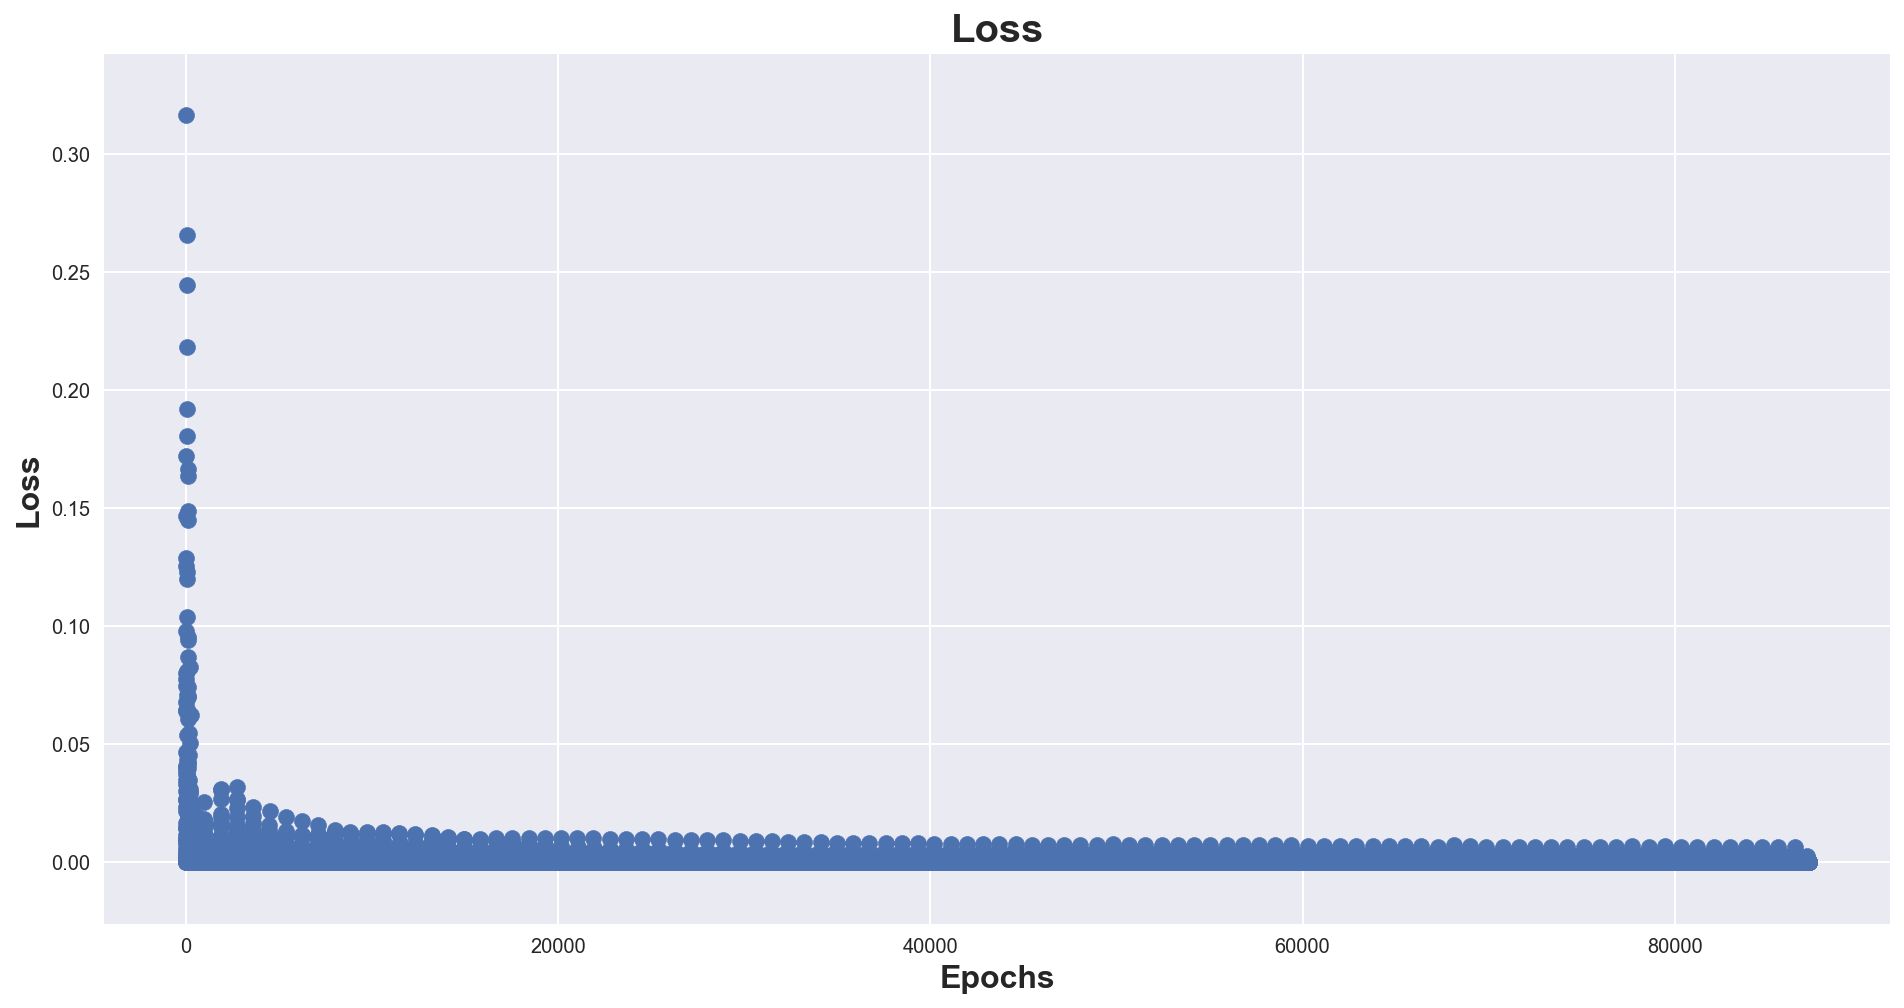

In [41]:
plt.title('Loss')
plt.scatter(x=np.arange(0, len(loss_list)), y=loss_list)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

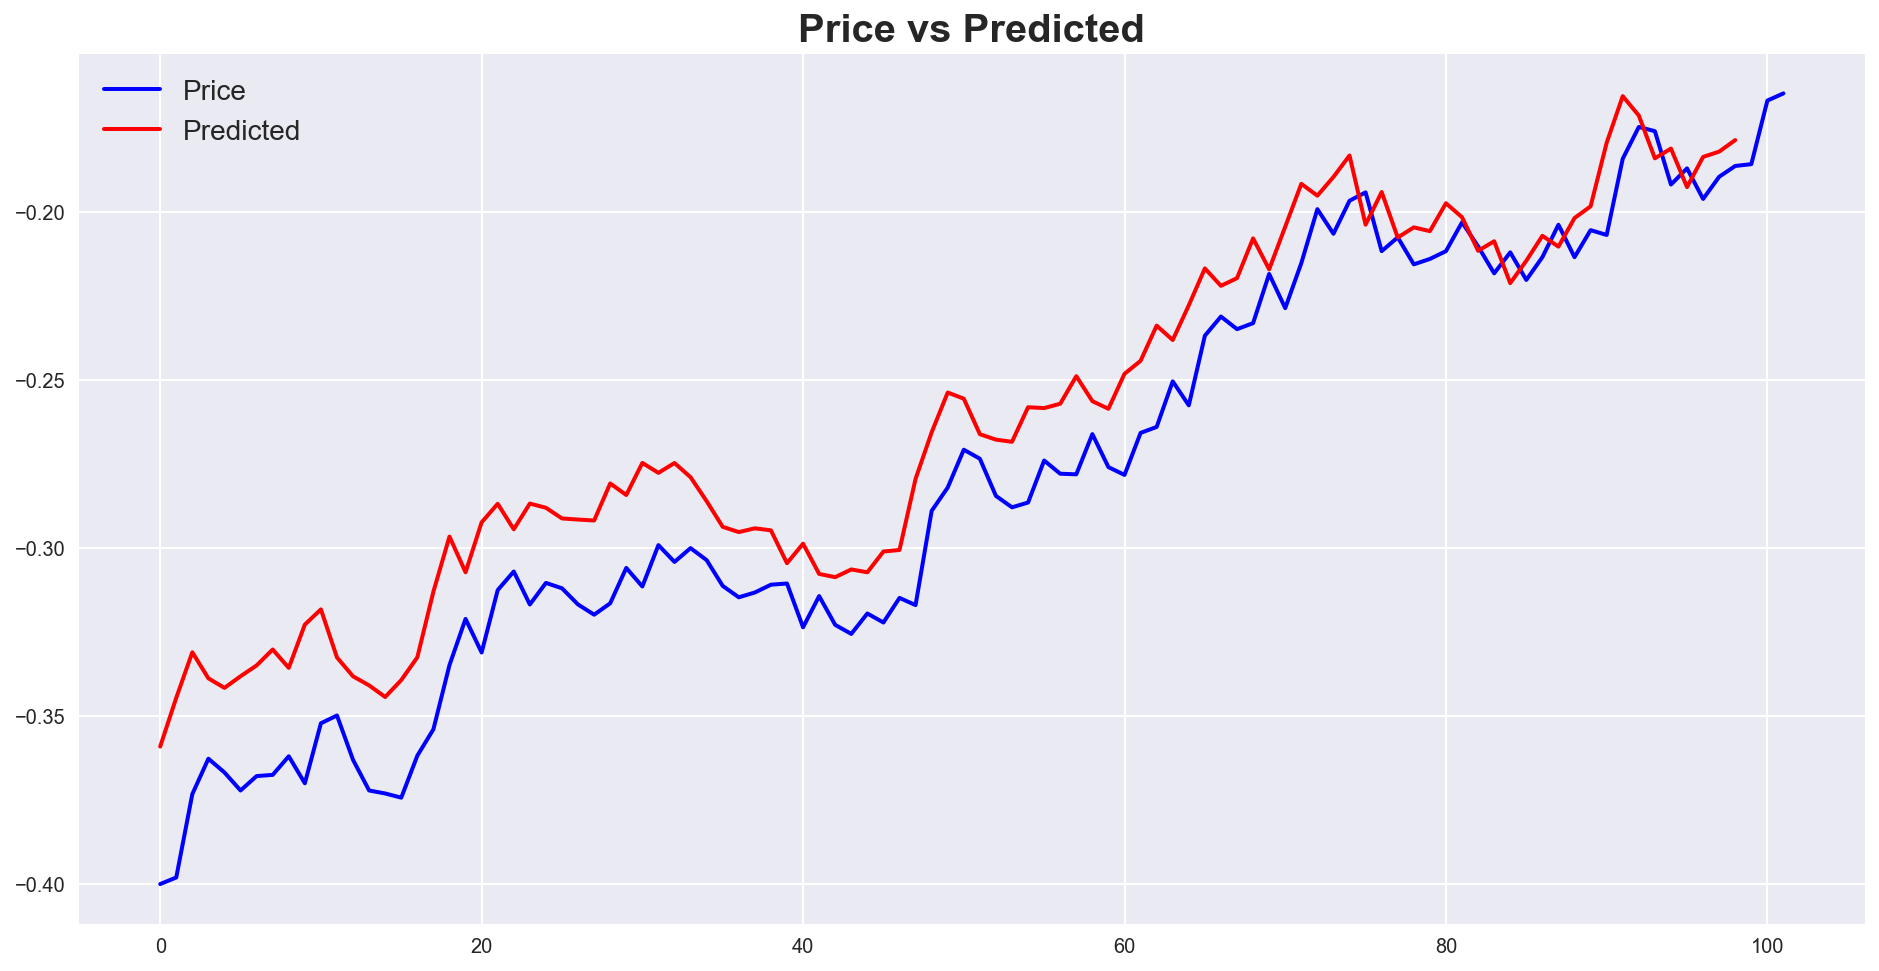

In [42]:
plt.figure()
plt.plot(yTest,label='Price', color='blue')
plt.plot(test_pred_list,label='Predicted',color='red')
plt.title('Price vs Predicted')
plt.legend(loc='upper left')
plt.show()